In [1]:
# Import libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.pipeline as spl
import sklearn.kernel_ridge as skr
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.neural_network as snn
import sklearn.metrics as sme
import sklearn.decomposition as sdc
import sklearn.cross_decomposition as skd
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
#     Performed poorly using Standard and MinMax scalers. Trying with LOOCV to see if predictions stabilize.
#     Does not appear to stabilize predictions with LOOCV (using StandardScaler())
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function?
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

In [5]:
X_train,X_test,y_train,y_test,train_index,test_index = util.set_split(X_all_c,per_change,1,5/len(X_all_c))
# Cross validation
cvn = 8
# Choose scaling
X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)
X0_mm,scaler_mm,X_test_mm = util.model_scale(skp.MinMaxScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)
X0_ma,scaler_ma,X_test_ma = util.model_scale(skp.MaxAbsScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)
X0_rs,scaler_rs,X_test_rs = util.model_scale(skp.RobustScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)
# Feature selection
sel = skf.SelectKBest(skf.f_regression,k=X0_ss0.shape[1])
X0_ss = sel.fit_transform(X0_ss0,y_train)
X_test_ss = (sel.transform(X_test_ss0.reshape(X_test_ss0.shape[0],X_test_ss0.shape[1]*X_test_ss0.shape[2]))).reshape((X_test_ss0.shape[0],1,-1))

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


In [6]:
scoring = 'max_error'
print(y_test)
print(y_test.mean())
print(y_train.mean())

[0.66153846 0.95238095 0.1875     0.74418605 0.48571429]
0.6062639492290656
0.6326064447010488


In [7]:
alphas = np.logspace(-9,-2,10)

In [8]:
lr = slm.LinearRegression()
est_lr = lr.fit(X0_ss,y_train)
results_lr = est_lr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_lr)

[0.58925128 0.73266988 0.67123521 0.88451997 0.53614235]


In [9]:
br_grid = {'alpha_1': alphas[-5:-4], 'alpha_2': alphas[-5:-4]}

best_params = util.gridsearch_pickparams(slm.BayesianRidge(),cvn,
                                         br_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train.ravel(),scoring,8)
br = slm.BayesianRidge(alpha_1=best_params['alpha_1'],alpha_2=best_params['alpha_2'])
br.fit(X0_ss, y_train)
results_br = np.asarray(br.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()
print(results_br)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
[0.58957165 0.73264792 0.671208   0.8846181  0.53623232]


In [10]:
mlp_grid = {'hidden_layer_sizes': [(X_train.shape[1],X_train.shape[2])],
          'activation': ['relu'],
          'alpha': alphas,
          'epsilon': [1e0],
          'solver': ['adam'],
          'max_iter':[5000]}

best_params = util.gridsearch_pickparams(snn.MLPRegressor(),
                                         cvn,mlp_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train,scoring,-1)

mlp = snn.MLPRegressor(hidden_layer_sizes=best_params["hidden_layer_sizes"], 
                        activation=best_params["activation"],
                        solver=best_params["solver"],
                        alpha=best_params['alpha'],
                        epsilon=best_params["epsilon"],
                        max_iter=5000, 
                        n_iter_no_change=500, 
                        verbose=True,
                        early_stopping=True,
                        random_state=1,
                        batch_size=len(X0_ss)//cvn)

mlp.fit(X0_ss,y_train)
results_mlp = mlp.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))

print(results_mlp)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Iteration 1, loss = 0.22107222
Validation score: -4.988632
Iteration 2, loss = 0.21877637
Validation score: -4.926170
Iteration 3, loss = 0.21568071
Validation score: -4.848840
Iteration 4, loss = 0.21164448
Validation score: -4.766421
Iteration 5, loss = 0.20777362
Validation score: -4.670411
Iteration 6, loss = 0.20314136
Validation score: -4.567485
Iteration 7, loss = 0.19821170
Validation score: -4.459980
Iteration 8, loss = 0.19360658
Validation score: -4.350408
Iteration 9, loss = 0.18857477
Validation score: -4.238966
Iteration 10, loss = 0.18366766
Validation score: -4.124229
Iteration 11, loss = 0.17879635
Validation score: -3.999200
Iteration 12, loss = 0.17329464
Validation score: -3.881707
Iteration 13, loss = 0.16812119
Validation score: -3.762682
Iteration 14, loss = 0.16333047
Validation score: -3.638774
Iteration 15, loss = 0.15801246
Validation score: -3.515298
Iteration 16, loss = 0.15279542
Validation score

In [11]:
lasso = slm.LassoCV(
    alphas=alphas,
    cv=cvn, 
    verbose=True,
    random_state=1,
    max_iter=100000,
    tol=1e-3,
    n_jobs=-1)

est_ls = lasso.fit(X0_ss,y_train)
results_ls = est_ls.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_ls)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
................................................................................[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.3s finished


[0.70312681 0.65670787 0.51664859 0.89789566 0.30852296]


In [12]:
ridge = slm.RidgeCV(
    alphas=[1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4],
    scoring=scoring,
    cv=cvn)

est_rr = ridge.fit(X0_ss,y_train)
results_rr = est_rr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_rr)

[0.62782794 0.6307729  0.59343793 0.73741003 0.61820002]


In [13]:
lars = slm.LarsCV(
    cv=cvn, 
    max_iter=1000,
    max_n_alphas=10000,
    verbose=True,
    normalize=False,
    eps=np.finfo(float).eps,
    n_jobs=-1)

est_lars = lars.fit(X0_ss,y_train)
results_lars = est_lars.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_lars)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[0.64009701 0.62387311 0.63765439 0.64541764 0.61764494]


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.0s finished


In [14]:
krr_grid = {'kernel': ['linear','rbf'],
          'alpha': [alphas]}

best_params = util.gridsearch_pickparams(skr.KernelRidge(),
                                         cvn,krr_grid,scaler_ss,X_train,train_index,
                                         X_test,test_index,pre_updrs_off,y_train,scoring,-1)
krr = skr.KernelRidge(kernel=best_params['kernel'],alpha=best_params['alpha'])
krr.fit(X0_ss, y_train)
results_krr = krr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_krr)

Fitting 8 folds for each of 2 candidates, totalling 16 fits
[0.47935171 0.17238    0.38277573 0.64723044 0.64100393]


In [15]:
gsc = slm.ElasticNetCV(
    alphas=alphas,
    cv=cvn, 
    max_iter=10000,
    verbose=True,
    n_jobs=-1)

est_en = gsc.fit(X0_ss,y_train)
results_en = est_en.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_en)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
................................................................................[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.3s finished


[0.67658734 0.66689825 0.56280611 0.89704385 0.28457506]


In [16]:
pls_grid = {'n_components': np.flip(np.arange(5,int(len(X_train)))),
            'scale': [True,False]}

best_params = util.gridsearch_pickparams(skd.PLSRegression(),cvn,
                                         pls_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train,scoring,-1)
pls = skd.PLSRegression(n_components=best_params['n_components'],scale=best_params['scale'],max_iter=10000)
pls.fit(X0_ss, y_train)
results_pls = (pls.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()

print(results_pls)

Fitting 8 folds for each of 74 candidates, totalling 592 fits
[0.58698827 0.72740447 0.6760591  0.88264421 0.53697087]


In [17]:
pcr = spl.make_pipeline(sdc.PCA(),slm.LinearRegression())
pcr.fit(X0_ss, y_train)
results_pcr = np.asarray(pcr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()
print(results_pcr)

[0.5895642  0.73261417 0.67175206 0.8844495  0.53611267]


In [18]:
# omp = slm.OrthogonalMatchingPursuitCV(normalize=True,cv=cvn,max_iter=len(X_train)//2,verbose=True)
# omp.fit(X0_ss, y_train)
# results_omp = np.asarray(omp.predict(X_test_ss.reshape([X_test_ss.shape[0],
#                                            X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()
# print(results_omp)
results_omp = results_pcr

In [19]:
rsr = slm.RANSACRegressor(random_state=1,min_samples=len(X0_ss)).fit(X0_ss, y_train)
results_rsr = rsr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]])).ravel()
print(results_rsr)

[0.58952738 0.73254629 0.67040202 0.88475614 0.53650374]


In [20]:
# Very slow on leave one out
# ard_grid = {'alpha_1': alphas[-5:-4], 'alpha_2': alphas[-5:-4], 'lambda_1': alphas[-5:-4], 'lambda_2': alphas[-5:-4]}
# best_params = util.gridsearch_pickparams(slm.ARDRegression(),cvn,
#                                          ard_grid,scaler_ss,X_train,
#                                          train_index,X_test,test_index,pre_updrs_off,y_train,scoring,8)
# ard = slm.ARDRegression(alpha_1=best_params['alpha_1'],alpha_2=best_params['alpha_2'],
#                        lambda_1=best_params['lambda_1'],lambda_2=best_params['lambda_2'])
# ard.fit(X0_ss,y_train)
# results_ard = np.asarray(ard.predict(X_test_ss.reshape([X_test_ss.shape[0],
#                                            X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()

In [21]:

svr_grid = {'kernel': ['linear','rbf'],
          'epsilon': [1e-1,1.5e-1,2.5e-1],
          'C': [1e0,1e1,1e2]}
best_params = util.gridsearch_pickparams(svm.SVR(),
                                         cvn,svr_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train,scoring,-1)
svr = svm.SVR(kernel=best_params['kernel'],epsilon=best_params['epsilon'])
svr.fit(X0_ss, y_train)
results_svr = np.asarray(svr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()
print(results_svr)

Fitting 8 folds for each of 18 candidates, totalling 144 fits
[0.57846906 0.59501013 0.58836125 0.57957833 0.55833727]


In [22]:
gbr_grid = {'max_depth':[3,6,9,12,15,20,100]}
best_params = util.gridsearch_pickparams(ske.GradientBoostingRegressor(random_state=1),cvn,
                                         gbr_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train,scoring,8)
gbr = ske.GradientBoostingRegressor(random_state=1,learning_rate=0.001,max_depth=best_params['max_depth'],n_estimators=100)
gbr.fit(X0_ss, y_train)
results_gbr = np.asarray(gbr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()

Fitting 8 folds for each of 7 candidates, totalling 56 fits


(0.0, 2.0)

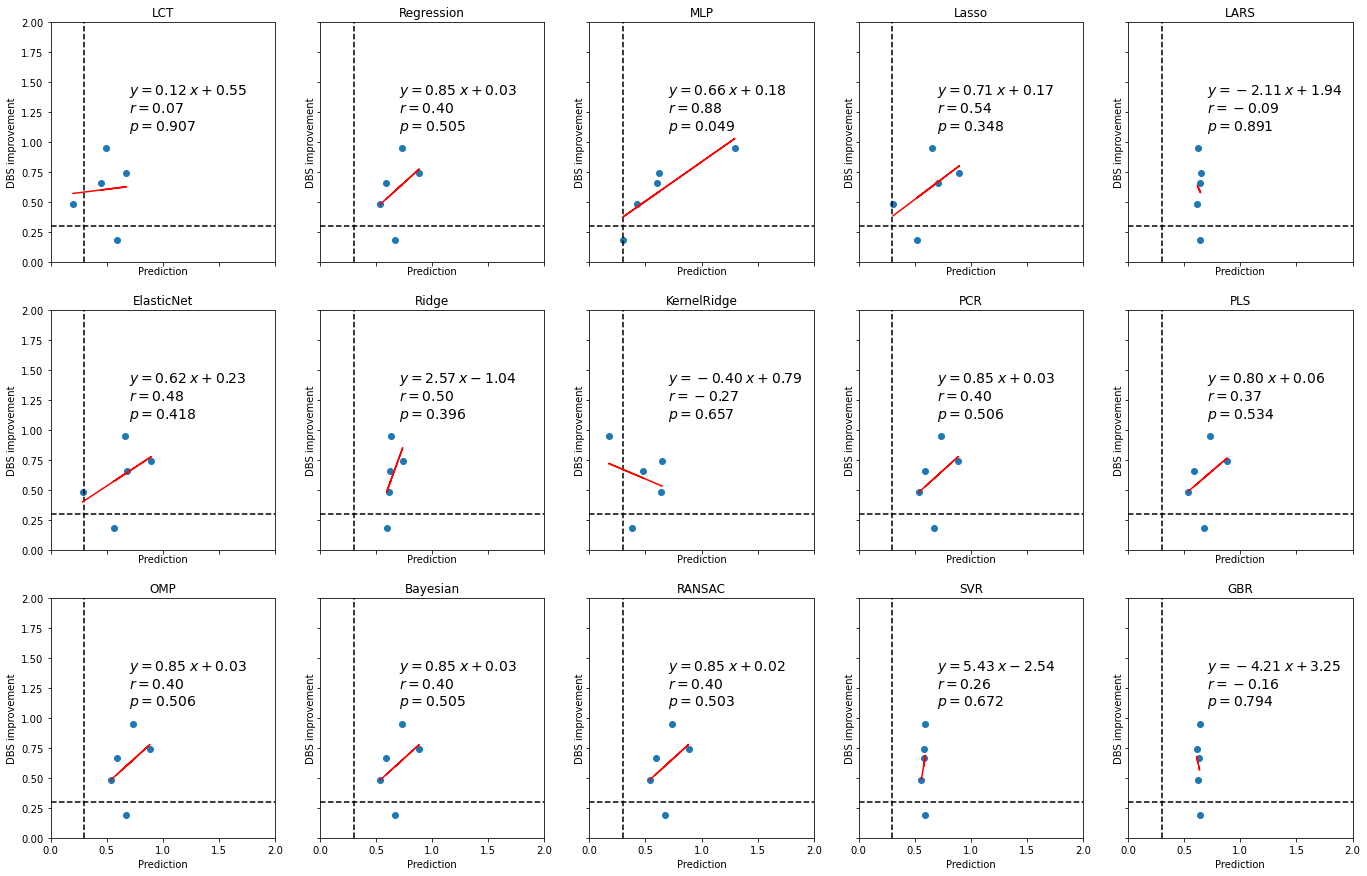

In [23]:
util.eval_prediction(np.vstack((pre_imp[test_index],
                               results_lr.ravel(),
                               results_mlp,
                               results_ls,
                               results_lars,
                               results_en,
                               results_rr.ravel(),
                               results_krr.ravel(),
                               results_pcr,
                               results_pls,
                               results_omp,
                               results_br,
                               results_rsr,
                               results_svr,
                               results_gbr)),
                               y_test,
                               ['LCT','Regression','MLP','Lasso','LARS',
                                'ElasticNet','Ridge','KernelRidge','PCR',
                                'PLS','OMP','Bayesian','RANSAC','SVR','GBR'],(70,5))
plt.ylim([0,2])
plt.xlim([0,2])

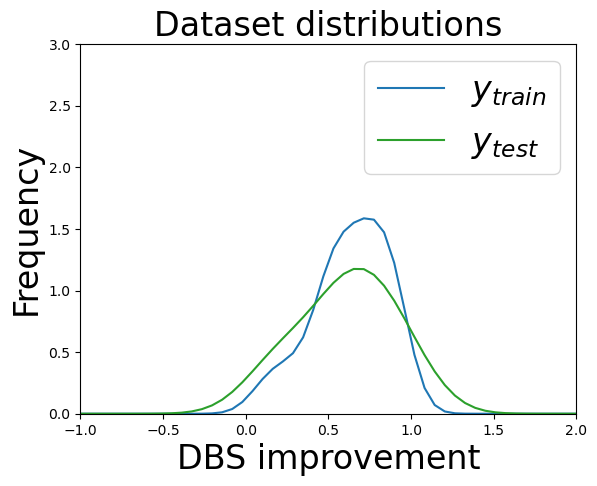

In [24]:
density_train = stats.gaussian_kde(y_train)
density_test = stats.gaussian_kde(y_test)
n, x, _ = plt.hist(y_train, bins=np.linspace(-1, 2, 50), 
                   histtype=u'step', density=True,color='tab:blue',linewidth=0)  
plt.plot(x, density_train(x),color='tab:blue',label=r'$y_{train}$')
n, y, _ = plt.hist(y_test, bins=np.linspace(-1, 2, 50), 
                   histtype=u'step', density=True,color='tab:blue',linewidth=0)  
plt.plot(y, density_test(y),color='tab:green',label=r'$y_{test}$')
plt.legend(fontsize=24)
plt.xlim([-1,2])
plt.ylim([0,3])
plt.xlabel('DBS improvement',fontsize=24)
plt.ylabel('Frequency',fontsize=24)
plt.title('Dataset distributions',fontsize=24)
plt.show()

In [25]:
# np.save('X_test.npy',X_test)
# np.save('X_train.npy',X_train)
# np.save('y_test.npy',y_test)
# np.save('y_train.npy',y_train)
# np.save('test_index.npy',test_index)
# np.save('train_index.npy',train_index)